In [1]:
import modeller as md
from modeller.scripts import complete_pdb
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt


x = 3
pdb = '3kc6'
chain = 'A'
target = 'Assign_3'
ali_file = str(Path('../data/align2d') / f'{target}-{pdb}.ali')
pdb_file = str(Path('../data/pdb') / f'{pdb}.pdb')

pdb_files = glob(str(Path('../data/model_single')/'*.pdb'))
output = Path('../data/evaluate_model')
output.mkdir(exist_ok=True)

# log.verbose()    # request verbose output

In [2]:
# for template

env = md.Environ()
env.libs.topology.read(file='$(LIB)/top_heav.lib') # read topology
env.libs.parameters.read(file='$(LIB)/par.lib') # read parameters

model_template = complete_pdb(env,pdb_file)
# Assess with DOPE:
s_template = md.Selection(model_template)   # all atom selection
s_template.assess_dope(output='ENERGY_PROFILE NO_REPORT',
                       file=str(output / f'{pdb}.profile'),
                       normalize_profile=True,
                       smoothing_window=10
                       )


                         MODELLER 10.6, 2024/10/17, r12888

     PROTEIN STRUCTURE MODELLING BY SATISFACTION OF SPATIAL RESTRAINTS


                     Copyright(c) 1989-2024 Andrej Sali
                            All Rights Reserved

                             Written by A. Sali
                               with help from
              B. Webb, M.S. Madhusudhan, M-Y. Shen, G.Q. Dong,
          M.A. Marti-Renom, N. Eswar, F. Alber, M. Topf, B. Oliva,
             A. Fiser, R. Sanchez, B. Yerkovich, A. Badretdinov,
                     F. Melo, J.P. Overington, E. Feyfant
                 University of California, San Francisco, USA
                    Rockefeller University, New York, USA
                      Harvard University, Cambridge, USA
                   Imperial Cancer Research Fund, London, UK
              Birkbeck College, University of London, London, UK


Kind, OS, HostName, Kernel, Processor: 4, Linux gpuless 6.8.0-49-generic x86_64
Date and time of compilation 

-23476.951171875

In [3]:
env = md.Environ()
env.libs.topology.read(file='$(LIB)/top_heav.lib') # read topology
env.libs.parameters.read(file='$(LIB)/par.lib') # read parameters

# read model file
model = complete_pdb(env, pdb_files[x])

# Assess with DOPE:
s = md.Selection(model)   # all atom selection
s.assess_dope(output='ENERGY_PROFILE NO_REPORT',
              file=str(output / f'{target}.profile'),
              normalize_profile=True,
              smoothing_window=15
             )

zscore = model.assess_normalized_dope()

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ASN:OXT  ASN
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      759
Number of all, selected real atoms                :     6021    6021
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):  1067795
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

In [5]:
def r_enumerate(seq):
    """Enumerate a sequence in reverse order"""
    # Note that we don't use reversed() since Python 2.3 doesn't have it
    num = len(seq) - 1
    while num >= 0:
        yield num, seq[num]
        num -= 1

def get_profile(profile_file, seq):
    """Read `profile_file` into a Python array, and add gaps corresponding to
       the alignment sequence `seq`."""
    # Read all non-comment and non-blank lines from the file:
    f = open(profile_file)
    vals = []
    for line in f:
        if not line.startswith('#') and len(line) > 10:
            spl = line.split()
            vals.append(float(spl[-1]))
    # Insert gaps into the profile corresponding to those in seq:
    for n, res in r_enumerate(seq.residues):
        for gap in range(res.get_leading_gaps()):
            vals.insert(n, None)
    # Add a gap at position '0', so that we effectively count from 1:
    vals.insert(0, None)
    return vals


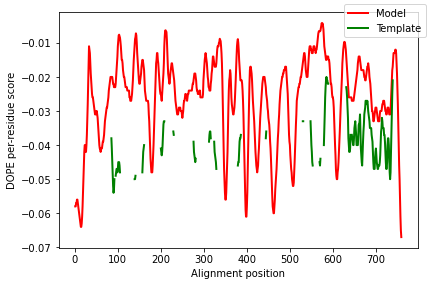

In [6]:
name = Path(pdb_files[x]).name

e = md.Environ()
a = md.Alignment(e, file=ali_file)

template = get_profile(str(output/f'{pdb}.profile'), a[pdb+chain])
model = get_profile(str(output/f'{target}.profile'), a[target])

# Plot the template and model profiles in the same plot for comparison:
fig, ax = plt.subplots()
ax.set_xlabel('Alignment position')
ax.set_ylabel('DOPE per-residue score')
ax.plot(model, color='red', linewidth=2, label='Model')
ax.plot(template, color='green', linewidth=2, label='Template')
fig.legend()
fig.tight_layout()
fig.savefig(str(output / f'dope_profile_{name}.png'), dpi=300)